In [1]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
import warnings

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
import SEDR

In [3]:
random_seed = 2023
SEDR.fix_seed(random_seed)

In [4]:
# adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
# adata = sc.read_h5ad('../data/BaristaSeq/Slice_2_removed.h5ad')
adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
# adata = sc.read_h5ad('../data/human/adata_sp.h5ad')
print(adata)
adata.var_names_make_unique()
n_clusters = len(adata.obs['Region'].unique())

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'


In [5]:
n_clusters = len(adata.obs['Region'].unique())
print(n_clusters)
adata.obsm['X_pca'] = adata.X
num_genes = adata.X.shape[1]
graph_dict = SEDR.graph_construction(adata, 12)
print(graph_dict)
max_gs = 399
mask_ratio = 0.1
mask = np.random.binomial(1, mask_ratio, size=(num_genes, max_gs))

11
{'adj_norm': tensor(indices=tensor([[   0,    0,    0,  ..., 4838, 4838, 4838],
                       [   0,   47,   83,  ..., 4265, 4352, 4838]]),
       values=tensor([0.0667, 0.0667, 0.0690,  ..., 0.0598, 0.0488, 0.0500]),
       size=(4839, 4839), nnz=72235, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 4838, 4838, 4838],
                       [   0,   47,   83,  ..., 4265, 4352, 4838]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(4839, 4839), nnz=72235, dtype=torch.float64,
       layout=torch.sparse_coo), 'norm_value': 0.5015472063837734}


/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/SEDR-1.0.0-py3.10.egg/SEDR/graph_func.py:59: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

  0%|                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/SEDR-1.0.0-py3.10.egg/SEDR/SEDR_model.py:105: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  total_idx = torch.range(0, self.cell_num-1, dtype=torch.float32).to(self.device)
  0%|                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/SEDR-1.0.0-py3.10.egg/SEDR/SEDR_model.py:275: UserWarning: To copy construct

In [7]:
def mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR', random_seed=2023):
    np.random.seed(random_seed)
    modelNames = 'EEE'
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[use_rep]), n_clusters, modelNames)
    mclust_res = np.array(res[-2])-1

    adata.obs[key_added] = mclust_res
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [8]:
adata = mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


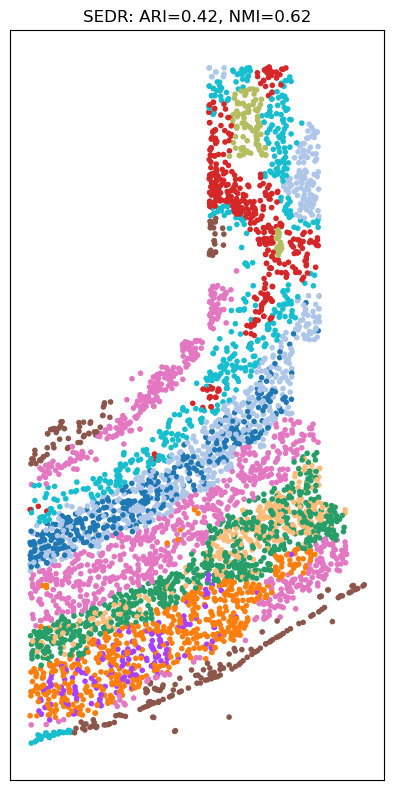

In [10]:
sub_adata = adata[~pd.isnull(adata.obs['Region'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Region'], sub_adata.obs['SEDR'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['Region'], sub_adata.obs['SEDR'])
fig, axes = plt.subplots(1,1,figsize=(6, 8))
# sc.pl.spatial(adata, color='SEDR', ax=axes, show=False, spot_size=20)
sc.pl.spatial(adata, color='SEDR', ax=axes, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
axes.set_title('SEDR: ARI=%.2f, NMI=%.2f' % (ARI, NMI))
axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
# output_dir = ('./SEDR_ARI_NMI')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# output_path = os.path.join(output_dir, "SEDR_osmfish_ARI.svg")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [11]:
output_dir1 = ('../featrue/osmish')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"SEDR.h5ad")
adata.write_h5ad(output_path)

In [ ]:
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata, min_dist=0.2, spread=0.4)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color='SEDR', ax=axes, show=False,size=60,legend_loc=None)

# 设置标题
axes.set_title('SEDR')
axes.set_aspect(1)

for cluster in adata.obs['SEDR'].unique():
    # 计算每个类别的 UMAP 中心点
    cluster_points = adata[adata.obs['SEDR'] == cluster].obsm['X_umap']
    x_mean, y_mean = cluster_points[:, 0].mean(), cluster_points[:, 1].mean()

    # 在中心点处添加标签
    axes.text(
        x=x_mean,  # X 坐标
        y=y_mean,  # Y 坐标
        s=cluster,  # 标签内容
        fontsize=10,
        ha='center',  # 水平对齐
        va='center',  # 垂直对齐
        color='black',  # 标签颜色
        fontweight='bold'  # 标签字体加粗
    )

axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_path = os.path.join('./clustering_results', f"SEDR_osmfish.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
